In [ ]:
import requests

# URL of the models ZIP file
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8Ptx0Quj9P2MoYqLrv5X7g/models.zip'

# Download the models file
response = requests.get(url)


# Save the file locally
zip_filename = 'models.zip'
with open(zip_filename, 'wb') as f:
    f.write(response.content)

In [ ]:
!unzip -o models.zip

Archive:  models.zip
   creating: models/
  inflating: models/zs_forecast.pkl  
  inflating: models/.DS_Store        
   creating: models/zero_shot_model/
  inflating: models/zero_shot_model/model.safetensors  
  inflating: models/zero_shot_model/config.json  
  inflating: models/zero_shot_model/training_args.bin  
   creating: models/finetuned_forecast_model/
  inflating: models/finetuned_forecast_model/model.safetensors  
  inflating: models/finetuned_forecast_model/config.json  
  inflating: models/finetuned_forecast_model/training_args.bin  
  inflating: models/forecast_finetuned.pkl  


In [ ]:
! [ -d "tsfm" ] && rm -rf tsfm
! git clone --depth 1 --branch v0.2.9 https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 130 (delta 16), reused 55 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (130/130), 8.28 MiB | 14.44 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Note: switching to 'f856e5bfc739dc23b2a2dace13bbe3b45d21ceee'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [ ]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

# Install the tsfm library
! pip install ".[notebooks]" seaborn==0.13.2

%cd ../

print("All the required libraries are installed.")

/content/tsfm
Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

/content
All the required libraries are installed.


In [ ]:
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# TSFM libraries
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

In [ ]:
bitcoin_data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/-HFvh0XxVB1Babm-RmFGCA/btcusd-1-min-data.csv')
bitcoin_data.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [ ]:
bitcoin_data.tail()

,Timestamp,Open,High,Low,Close,Volume
6698276,1.728950e+09,66056.0,66056.0,66056.0,66056.0,0.061340
6698277,1.728950e+09,66054.0,66062.0,66054.0,66062.0,0.005927
6698278,1.728950e+09,66070.0,66070.0,66070.0,66070.0,0.000480
6698279,1.728950e+09,66070.0,66118.0,66070.0,66098.0,0.483483
6698280,NaN,57854.0,57864.0,57835.0,57835.0,1.353466


In [ ]:
bitcoin_data

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6698276,1.728950e+09,66056.00,66056.00,66056.00,66056.00,0.061340
6698277,1.728950e+09,66054.00,66062.00,66054.00,66062.00,0.005927
6698278,1.728950e+09,66070.00,66070.00,66070.00,66070.00,0.000480
6698279,1.728950e+09,66070.00,66118.00,66070.00,66098.00,0.483483


In [ ]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6698281 entries, 0 to 6698280
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 306.6 MB


In [ ]:
# Check the number of entries in the dataset
len(bitcoin_data)

6698281

In [ ]:
bitcoin_data.isna().sum()

,0
Timestamp,1
Open,0
High,0
Low,0
Close,0
Volume,0


In [ ]:
bitcoin_data['Timestamp']

,Timestamp
0,1.325412e+09
1,1.325412e+09
2,1.325412e+09
3,1.325412e+09
4,1.325412e+09
...,...
6698276,1.728950e+09
6698277,1.728950e+09
6698278,1.728950e+09
6698279,1.728950e+09


In [ ]:
bitcoin_data['Timestamp'] = bitcoin_data['Timestamp'].ffill()
bitcoin_data['Timestamp']

,Timestamp
0,1.325412e+09
1,1.325412e+09
2,1.325412e+09
3,1.325412e+09
4,1.325412e+09
...,...
6698276,1.728950e+09
6698277,1.728950e+09
6698278,1.728950e+09
6698279,1.728950e+09


In [ ]:
bitcoin_data.isna().sum()

,0
Timestamp,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [ ]:
bitcoin_data['Timestamp'] = pd.to_datetime(bitcoin_data['Timestamp'], unit='s')
bitcoin_data

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
1,2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2,2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
3,2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
4,2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6698276,2024-10-14 23:57:00,66056.00,66056.00,66056.00,66056.00,0.061340
6698277,2024-10-14 23:58:00,66054.00,66062.00,66054.00,66062.00,0.005927
6698278,2024-10-14 23:59:00,66070.00,66070.00,66070.00,66070.00,0.000480
6698279,2024-10-15 00:00:00,66070.00,66118.00,66070.00,66098.00,0.483483


In [ ]:
bt_data_resampled = bitcoin_data.resample('1h', on='Timestamp').mean().dropna().reset_index()
bt_data_resampled

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:00:00,4.580000,4.580000,4.580000,4.580000,0.000000
1,2012-01-01 11:00:00,4.580000,4.580000,4.580000,4.580000,0.000000
2,2012-01-01 12:00:00,4.580000,4.580000,4.580000,4.580000,0.000000
3,2012-01-01 13:00:00,4.580000,4.580000,4.580000,4.580000,0.000000
4,2012-01-01 14:00:00,4.580000,4.580000,4.580000,4.580000,0.000000
...,...,...,...,...,...,...
111653,2024-10-14 20:00:00,65956.383333,65967.750000,65944.883333,65956.283333,0.741047
111654,2024-10-14 21:00:00,65859.300000,65868.066667,65850.533333,65857.916667,0.746750
111655,2024-10-14 22:00:00,66066.000000,66095.300000,66052.783333,66080.400000,1.717164
111656,2024-10-14 23:00:00,66141.516667,66154.800000,66125.166667,66136.666667,0.791954


In [ ]:
print(f"Checking for NA values after resampling:\n{bt_data_resampled.isna().sum()}\n")
print(f"Number of entries after resampling: {len(bt_data_resampled)}")

Checking for NA values after resampling:
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

Number of entries after resampling: 111658


In [ ]:
timestamp_column = "Timestamp"
target_columns = ["Close"]
observable_columns = ["Open","High","Low"]

In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future

In [ ]:
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    get_datasets,
)

# Get the length of the resampled data
data_length = len(bt_data_resampled)

# Define the indices for the train, validation, and test splits
train_start_index = 0
train_end_index = round(data_length * 0.8)  # First 80% for training

# Shift the start of evaluation back by the context length for proper prediction
eval_start_index = round(data_length * 0.8) - context_length  # Next 10% for validation
eval_end_index = round(data_length * 0.9)

# Same adjustment for the test set
test_start_index = round(data_length * 0.9) - context_length  # Final 10% for testing
test_end_index = data_length

# Store the split configuration for easy access
split_config = {
    "train": [train_start_index, train_end_index],
    "valid": [eval_start_index, eval_end_index],
    "test": [test_start_index, test_end_index],
}

In [ ]:
print(f"train_start_index: {train_start_index}, train_end_index: {train_end_index}")
print(f"eval_start_index: {eval_start_index}, eval_end_index: {eval_end_index}")
print(f"test_start_index: {test_start_index}, test_start_index: {test_end_index}")

train_start_index: 0, train_end_index: 89326
eval_start_index: 88814, eval_end_index: 100492
test_start_index: 99980, test_start_index: 111658


In [ ]:
# Define the column specifiers for the time series data
column_specifiers = {
    "timestamp_column": timestamp_column,  # Time reference column
    "target_columns": target_columns,  # Target variable (Close price)
    "observable_columns": observable_columns  # Observable variables (Open, High, Low prices)
}

# Configure the TimeSeriesPreprocessor
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,  # Model will use 512 past time points
    prediction_length=forecast_length,  # Model will predict 96 future time points
    scaling=True,  # Apply scaling to normalize the data
    encode_categorical=False,  # No categorical encoding needed
    scaler_type="standard"  # Use standard scaling
)

# Generate training, validation, and test datasets
# This method returns torch vectors for training and validation
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, bt_data_resampled, split_config
)

In [ ]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("models/zero_shot_model")

In [ ]:
zeroshot_trainer = Trainer(
    model=zeroshot_model,
)

zeroshot_trainer.evaluate(test_dataset)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 0.004468670580536127,
 'eval_model_preparation_time': 0.0115,
 'eval_runtime': 58.7429,
 'eval_samples_per_second': 197.181,
 'eval_steps_per_second': 24.65}

In [ ]:
# Set up the time series forecasting pipeline using the zero-shot model
zs_forecast_pipeline = TimeSeriesForecastingPipeline(
    # Use the zero-shot Tiny Time Mixer model
    model=zeroshot_model,
    # Specify the device (CPU in this case)
    device="cpu",
    # Time reference column
    timestamp_column=timestamp_column,
    # No additional identifier columns
    id_columns=[],
    # Target variable (Close price)
    target_columns=target_columns,
    # Frequency of time series data (hourly)
    freq="1h"
)

Device set to use cpu


In [ ]:
zs_forecast = zs_forecast_pipeline(tsp.preprocess(bt_data_resampled[test_start_index:test_end_index]))

In [ ]:
zs_forecast = pd.read_pickle("models/zs_forecast.pkl")
zs_forecast

,Timestamp,Close_prediction,Close
0,2023-06-13 06:00:00,"[1.1943724155426025, 1.1940672397613525, 1.193...","[1.1992197036743164, 1.1942342519760132, 1.197..."
1,2023-06-13 07:00:00,"[1.20014226436615, 1.1993000507354736, 1.19848...","[1.1942342519760132, 1.1970683336257935, 1.198..."
2,2023-06-13 08:00:00,"[1.1951535940170288, 1.1950392723083496, 1.194...","[1.1970683336257935, 1.1988980770111084, 1.198..."
3,2023-06-13 09:00:00,"[1.1976863145828247, 1.1973384618759155, 1.196...","[1.1988980770111084, 1.198929786682129, 1.2012..."
4,2023-06-13 10:00:00,"[1.1985995769500732, 1.1981526613235474, 1.197...","[1.198929786682129, 1.2012884616851807, 1.2023..."
...,...,...,...
11144,2024-09-24 20:00:00,"[3.7839460372924805, 3.786552667617798, 3.7883...","[3.7833235263824463, 3.798954963684082, 3.8006..."
11145,2024-09-24 21:00:00,"[3.7776033878326416, 3.7802209854125977, 3.781...","[3.798954963684082, 3.80069637298584, 3.574534..."
11146,2024-09-24 22:00:00,"[3.7897534370422363, 3.7923402786254883, 3.795...","[3.80069637298584, 3.5745348930358887, nan, na..."
11147,2024-09-24 23:00:00,"[3.7892282009124756, 3.7938363552093506, 3.796...","[3.5745348930358887, nan, nan, nan, nan, nan, ..."


Text(0.5, 1.0, 'Predicted vs Actual Close Price for Row 11')

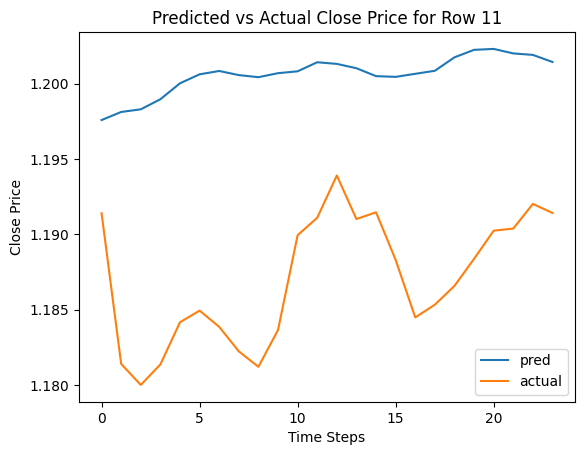

In [ ]:
# Create a DataFrame to compare the predicted and actual Close prices for Row 11
fcast_df = pd.DataFrame({
    "pred": zs_forecast.loc[11]['Close_prediction'],  # Predicted values for the next 24 time steps
    "actual": zs_forecast.loc[11]['Close'][:24]       # Actual values for the same time period
})

# Plot the predicted vs actual Close prices
ax = fcast_df.plot()

# Set labels and title for the plot
ax.set_xlabel("Time Steps")  # Label for the X-axis (time steps)
ax.set_ylabel("Close Price")  # Label for the Y-axis (Close price in USD)
ax.set_title("Predicted vs Actual Close Price for Row 11")  # Title of the plot

In [ ]:
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
    comparisons = pd.DataFrame()  # Initialize a new DataFrame to store comparisons
    comparisons[date_col] = forecast[date_col]  # Store the date or timestamp column

    # Initialize lists to store actual and predicted values
    actual = []
    pred = []

    # Loop through the forecast data
    for i in range(len(forecast)):
        # Append the prediction for the specified hour (e.g., 24 hours into the future)
        pred.append(forecast[prediction_col].values[i][hours_out - 1])
        # Append the actual value for the same hour
        actual.append(forecast[actual_col].values[i][hours_out - 1])

    # Add the actual and predicted values to the comparisons DataFrame
    comparisons['actual'] = actual
    comparisons['pred'] = pred

    return comparisons  # Return the comparisons DataFrame

In [ ]:
# Ensure required libraries are installed
!pip install --upgrade scikit-learn

# Import necessary libraries
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
# Get the predictions and actual values for 12 hours out
one_day_out_predictions = compare_forecast(zs_forecast, "Timestamp", "Close_prediction", "Close", 12)

# Drop rows where either 'pred' or 'actual' contains NaN values to ensure valid data
out = one_day_out_predictions.dropna(subset=["actual", "pred"])

# Calculate Root Mean Squared Error (RMSE)
# Use `np.sqrt` if older scikit-learn version is present
try:
    rms = '{:.10f}'.format(mean_squared_error(out['actual'], out['pred'], squared=False))
except TypeError:
    mse = mean_squared_error(out['actual'], out['pred'])
    rms = '{:.10f}'.format(np.sqrt(mse))

# Print the RMSE result
print(f"Root Mean Squared Error (RMSE): {rms}")

Root Mean Squared Error (RMSE): 0.0663050094


<Axes: title={'center': '0.0663050094'}, xlabel='Timestamp'>

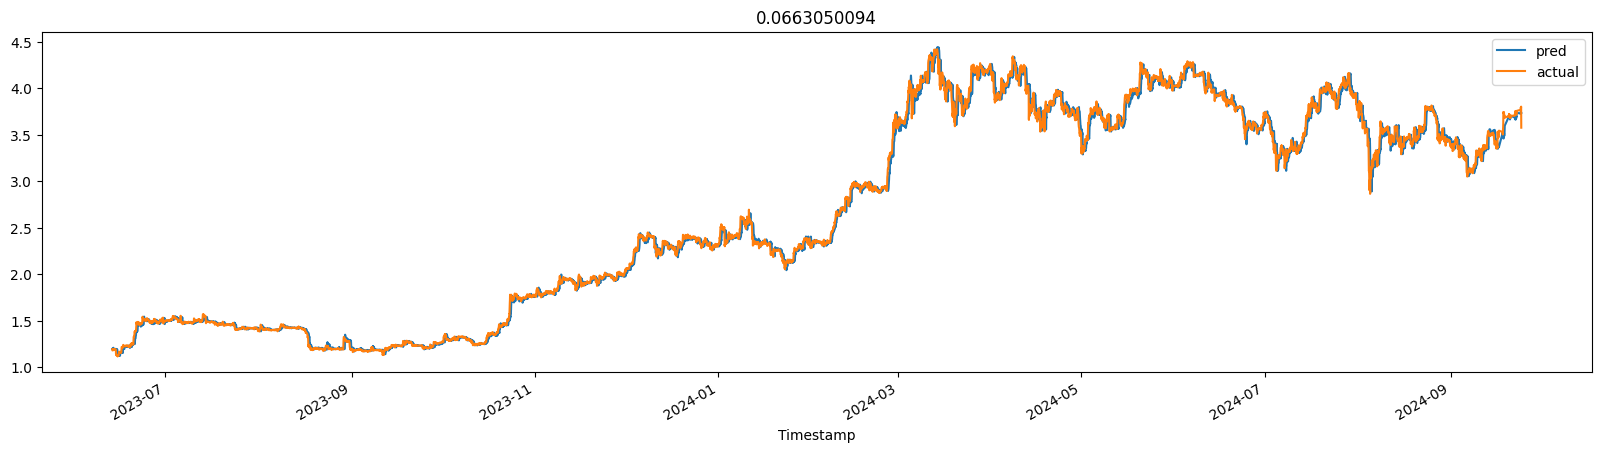

In [ ]:
out.plot(x="Timestamp", y=["pred", "actual"], figsize=(20, 5), title=str(rms))

In [ ]:
OUT_DIR = ""

# Important parameters for fine-tuning
learning_rate = 0.0001  # Set the learning rate for weight updates
num_epochs = 10  # Number of training epochs
batch_size = 32  # Number of samples processed in each batch

# Configure the TrainingArguments for fine-tuning
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),  # Directory to save model checkpoints and outputs
    overwrite_output_dir=True,  # Overwrite existing output directory
    learning_rate=learning_rate,  # Learning rate for the optimizer
    num_train_epochs=num_epochs,  # Total number of training epochs
    do_eval=True,  # Perform evaluation at the end of each epoch
    eval_strategy="epoch",  # Evaluate at the end of every epoch
    per_device_train_batch_size=batch_size,  # Training batch size
    per_device_eval_batch_size=batch_size,  # Evaluation batch size
    dataloader_num_workers=8,  # Number of workers for data loading
    save_strategy="epoch",  # Save model at the end of every epoch
    logging_strategy="epoch",  # Log metrics at the end of every epoch
    save_total_limit=1,  # Keep only the best model to save space
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Directory to store logs
    load_best_model_at_end=True,  # Load the best model based on evaluation loss at the end
    metric_for_best_model="eval_loss",  # Monitor evaluation loss to choose the best model
    greater_is_better=False,  # For loss metrics, lower is better
)

In [ ]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("models/finetuned_forecast_model")

In [ ]:
# Create the early stopping callback to prevent overfitting
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop training after 2 epochs of no improvement
    early_stopping_threshold=0.001,  # Minimum improvement required to continue training
)

# Callback for tracking model training
tracking_callback = TrackingCallback()

# Configure the optimizer (AdamW) and learning rate scheduler (OneCycleLR)
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)  # Optimizer for weight updates
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

In [ ]:
# Configure the Trainer for fine-tuning the model
finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,  # Fine-tuned version of the Tiny Time Mixer model
    args=finetune_forecast_args,  # Training arguments (learning rate, batch size, epochs, etc.)
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=valid_dataset,  # Validation dataset for evaluation during training
    callbacks=[early_stopping_callback, tracking_callback],  # Early stopping and tracking callbacks
    optimizers=(optimizer, scheduler),  # Optimizer (AdamW) and learning rate scheduler (OneCycleLR)
)

In [ ]:
finetune_forecast_trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.001100,0.001776
2,0.001100,0.001803
3,0.001000,0.001989


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[TrackingCallback] Mean Epoch Time = 1098.6306933561962 seconds, Total Train Time = 3446.7473838329315


TrainOutput(global_step=8319, training_loss=0.0010697751653382147, metrics={'train_runtime': 3446.7743, 'train_samples_per_second': 257.397, 'train_steps_per_second': 8.045, 'total_flos': 2633698209300480.0, 'train_loss': 0.0010697751653382147, 'epoch': 3.0})

In [ ]:
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=finetune_forecast_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq="1h"
)

Device set to use cpu


In [ ]:
#finetune_forecast_trainer.evaluate(tsp.preprocess(bt_data_resampled[test_start_index:test_end_index]))

In [ ]:
forecast_finetuned = pd.read_pickle("models/forecast_finetuned.pkl")
forecast_finetuned

,Timestamp,Close_prediction,Close
0,2023-06-13 06:00:00,"[1.1952520608901978, 1.195785641670227, 1.1953...","[1.1992197036743164, 1.1942342519760132, 1.197..."
1,2023-06-13 07:00:00,"[1.2000905275344849, 1.2002670764923096, 1.199...","[1.1942342519760132, 1.1970683336257935, 1.198..."
2,2023-06-13 08:00:00,"[1.1955355405807495, 1.1962144374847412, 1.195...","[1.1970683336257935, 1.1988980770111084, 1.198..."
3,2023-06-13 09:00:00,"[1.1975940465927124, 1.1981323957443237, 1.197...","[1.1988980770111084, 1.198929786682129, 1.2012..."
4,2023-06-13 10:00:00,"[1.198341965675354, 1.1988574266433716, 1.1989...","[1.198929786682129, 1.2012884616851807, 1.2023..."
...,...,...,...
11144,2024-09-24 20:00:00,"[3.7770535945892334, 3.776371717453003, 3.7751...","[3.7833235263824463, 3.798954963684082, 3.8006..."
11145,2024-09-24 21:00:00,"[3.772371768951416, 3.7719507217407227, 3.7702...","[3.798954963684082, 3.80069637298584, 3.574534..."
11146,2024-09-24 22:00:00,"[3.783233404159546, 3.783397674560547, 3.78383...","[3.80069637298584, 3.5745348930358887, nan, na..."
11147,2024-09-24 23:00:00,"[3.7820792198181152, 3.7841506004333496, 3.784...","[3.5745348930358887, nan, nan, nan, nan, nan, ..."


Text(0.5, 1.0, 'Predicted vs Actual Close Price for Row 11')

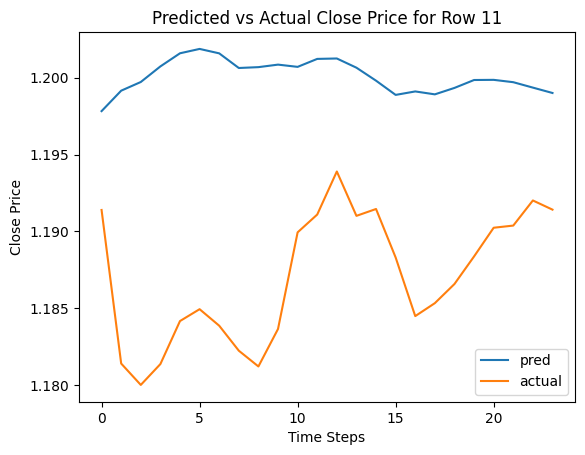

In [ ]:
# Create a DataFrame to compare the predicted and actual Close prices for Row 11
fcast_df = pd.DataFrame({
    "pred": forecast_finetuned.loc[11]['Close_prediction'],  # Predicted Close prices for the next 24 time steps
    "actual": forecast_finetuned.loc[11]['Close'][:24]       # Actual Close prices for the same period
})

# Plot the predicted vs actual Close prices
ax = fcast_df.plot()

# Set labels and title for the plot
ax.set_xlabel("Time Steps")  # X-axis represents the time steps (hours)
ax.set_ylabel("Close Price")  # Y-axis represents the Close price in USD
ax.set_title("Predicted vs Actual Close Price for Row 11")  # Title of the plot

<ipython-input-70-09b344934e82>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['actual'] = forecast_out['actual'].apply(lambda x: x[0] if isinstance(x, list) else x)
<ipython-input-70-09b344934e82>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_out['pred'] = forecast_out['pred'].apply(lambda x: x[0] if isinstance(x, list) else x)
<ipython-input-70-09b344934e82>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

Root Mean Squared Error (RMSE): 0.0674940496


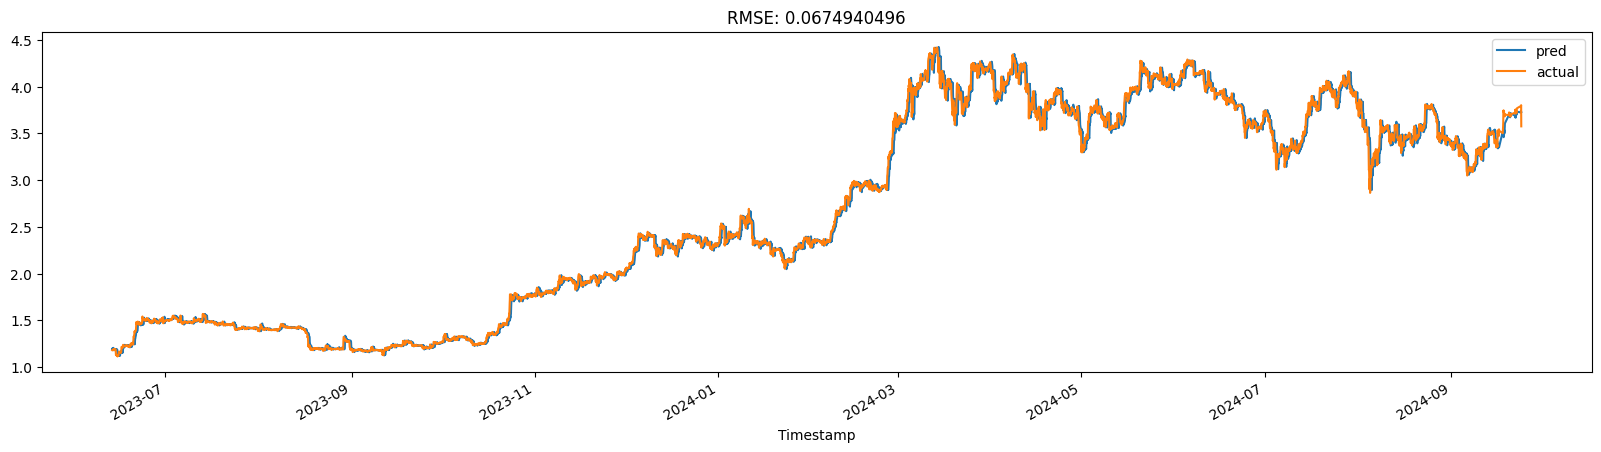

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Get the predictions and actual values for 12 hours out
forecast_predictions = compare_forecast(forecast_finetuned, "Timestamp", "Close_prediction", "Close", 12)

# Drop rows where either 'pred' or 'actual' contains NaN values
forecast_out = forecast_predictions.dropna(subset=["actual", "pred"])

# Flatten nested data if needed
forecast_out['actual'] = forecast_out['actual'].apply(lambda x: x[0] if isinstance(x, list) else x)
forecast_out['pred'] = forecast_out['pred'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Ensure columns are numeric
forecast_out['actual'] = pd.to_numeric(forecast_out['actual'], errors='coerce')
forecast_out['pred'] = pd.to_numeric(forecast_out['pred'], errors='coerce')

# Drop any rows with NaN values
forecast_out = forecast_out.dropna(subset=["actual", "pred"])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(forecast_out['actual'], forecast_out['pred'])

# Calculate Root Mean Squared Error (RMSE)
rms = '{:.10f}'.format(np.sqrt(mse))

# Print the calculated RMSE
print(f"Root Mean Squared Error (RMSE): {rms}")

# Plot the predicted vs actual values over time, with RMSE in the title
forecast_out.plot(x="Timestamp", y=["pred", "actual"], figsize=(20, 5), title=f"RMSE: {rms}")
plt.show()


In [ ]:
timestamps = pd.date_range('2023-01-01', periods=1000, freq='h')
values = np.sin(np.linspace(0, 100, 1000)) + np.random.normal(0, 0.1, 1000)

# Create the DataFrame
df = pd.DataFrame({'Timestamp': timestamps, 'Value': values})
df

,Timestamp,Value
0,2023-01-01 00:00:00,0.008705
1,2023-01-01 01:00:00,0.070032
2,2023-01-01 02:00:00,0.208042
3,2023-01-01 03:00:00,0.097050
4,2023-01-01 04:00:00,0.367820
...,...,...
995,2023-02-11 11:00:00,-0.754731
996,2023-02-11 12:00:00,-0.731102
997,2023-02-11 13:00:00,-0.796037
998,2023-02-11 14:00:00,-0.490378


In [ ]:
# Step 1: Set up parameters
timestamp_column = "Timestamp"
target_column = ["Value"]

# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Forecasting parameters
context_length = 512  # Use 512 time points from the past
forecast_length = 96   # Predict 96 time points into the future

# Step 2: Get the length of the dataset
data_length = len(df)

# Step 3: Define the indices for the train, validation, and test splits
train_start_index = 0
train_end_index = round(data_length * 0.7)  # First 70% for training
eval_start_index = round(data_length * 0.7) - context_length  # Next 10% for validation
eval_end_index = round(data_length * 0.8)
test_start_index = round(data_length * 0.8) - context_length  # Final 20% for testing
test_end_index = data_length

# Store the split configuration
split_config = {
    "train": [train_start_index, train_end_index],
    "valid": [eval_start_index, eval_end_index],
    "test": [test_start_index, test_end_index],
}

# Print the split indices
print(f"Train: {train_start_index} to {train_end_index}")
print(f"Validation: {eval_start_index} to {eval_end_index}")
print(f"Test: {test_start_index} to {test_end_index}")

Train: 0 to 700
Validation: 188 to 800
Test: 288 to 1000


In [ ]:
# Step 1: Define the column specifiers for time series data
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_column,
}

# Step 2: Initialize the preprocessor
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

# Step 3: Preprocess the data and get the train, validation, and test datasets
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, df, split_config
)

In [ ]:
OUT_DIR = "ttm_trained_models_practice/"

# Important parameters
learning_rate = 0.0001
num_epochs = 10
batch_size = 32

# Step 1: Set up training arguments
train_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# Step 2: Load the model for training
train_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm/TTM", revision="main", prediction_filter_length=24
)

# Step 3: Create early stopping callback and tracking callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=0.001,
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(train_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / batch_size),
)

# Step 4: Set up the Trainer for training
train_forecast_trainer = Trainer(
    model=train_forecast_model,
    args=train_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Step 5: Train the model
train_forecast_trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.210100,0.378381
2,1.178600,0.377367
3,0.953100,0.373320
4,0.825400,0.369325
5,0.633700,0.370190
6,0.496500,0.370501


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

[TrackingCallback] Mean Epoch Time = 1.2274208863576253 seconds, Total Train Time = 11.950058937072754


TrainOutput(global_step=18, training_loss=0.8828987148072984, metrics={'train_runtime': 11.9754, 'train_samples_per_second': 77.659, 'train_steps_per_second': 2.505, 'total_flos': 1380391649280.0, 'train_loss': 0.8828987148072984, 'epoch': 6.0})

In [ ]:
# Step 1: Preprocess the test data
test_data = tsp.preprocess(df[test_start_index:test_end_index])

# Step 2: Set up the forecasting pipeline with the trained model
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=train_forecast_model,  # Use the trained model here
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_column,
    freq="1h"
)

# Step 3: Make forecasts on the test dataset
forecasts = forecast_pipeline(test_data)

# Step 4: Compare forecasts and calculate RMSE
forecast_predictions = compare_forecast(forecasts, "Timestamp", "Value_prediction", "Value", 12)

# Drop rows with NaN values
forecast_out = forecast_predictions.dropna(subset=["actual", "pred"])

# Calculate RMSE
rms = '{:.10f}'.format(np.sqrt(mean_squared_error(forecast_out['actual'], forecast_out['pred'])))
print(f"Root Mean Squared Error (RMSE): {rms}")

# Step 5: Plot the predictions vs actual values
forecast_out.plot(x="Timestamp", y=["pred", "actual"], figsize=(20, 5), title=f"RMSE: {rms}")
plt.show()

Device set to use cpu


ValueError: setting an array element with a sequence.